In [1]:
!date

Fri Jan 15 13:31:32 PST 2021


# Compare kallisto-bustools to salmon alevin-alevin fry 

In [1]:
from kb_python.utils import import_matrix_as_anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

### Import cellranger barcodes as "ground truth barcodes"

In [2]:
cellranger_barcodes_file = "../../data/cellranger_barcodes/mouse-SRR8206317_v2.txt"
cr_barcodes = pd.read_csv(cellranger_barcodes_file, header=None, names=['bcs'])

cr_barcodes = cr_barcodes.bcs.apply(lambda x: x.split('-')[0]).values

cr_barcodes

array(['AAACCTGAGCTTTGGT', 'AAACCTGAGTACGATA', 'AAACCTGCAAGTCTAC', ...,
       'TTTGTCATCGACCAGC', 'TTTGTCATCTACTTAC', 'TTTGTCATCTGTACGA'],
      dtype=object)

## Import matrices

In [3]:
alevin_path = "../../data/alevin_out/mouse-SRR8206317_v2/quant/alevin/"
#alevin_path = "../../data/alevin_out/mouse-SRR8206317_v2/alevin-standard/alevin/"

alevin_raw_decoys = import_matrix_as_anndata(
    barcodes_path=os.path.join(alevin_path, "quants_mat_rows.txt"), 
    genes_path=os.path.join(alevin_path, "quants_mat_cols.txt"), 
    matrix_path=os.path.join(alevin_path, "quants_mat.mtx"))

In [4]:
alevin_raw_decoys

AnnData object with n_obs × n_vars = 367061 × 31119 

In [5]:
decoys = pd.read_csv("../../reference/mouse-mm10/full-decoy/decoys.txt", header = None, names=['decoys'])

alevin_raw = alevin_raw_decoys[:, ~alevin_raw_decoys.var.index.isin(decoys['decoys'])].copy()

In [6]:
alevin_raw

AnnData object with n_obs × n_vars = 367061 × 31053 

In [7]:
kb_path = "../../data/kallisto_out/mouse-SRR8206317_v2/count/"

kb_raw = import_matrix_as_anndata(
    barcodes_path=os.path.join(kb_path, "output.barcodes.txt"), 
    genes_path=   os.path.join(kb_path, "output.genes.txt"), 
    matrix_path=  os.path.join(kb_path, "output.mtx"))

In [8]:
kb_raw

AnnData object with n_obs × n_vars = 332970 × 31053 

In [9]:
print(kb_raw.var.shape[0] - alevin_raw.var.shape[0])
print(False in kb_raw.var.index == alevin_raw.var.index)

print(kb_raw)
print(alevin_raw)

0
False
AnnData object with n_obs × n_vars = 332970 × 31053 
AnnData object with n_obs × n_vars = 367061 × 31053 


## Basic process

In [10]:
def basic_process(A):
    '''
    sum counts per cell
    count ngenes per cell
    filter out cells with zero genes
    '''
    adata = A.copy()
    adata.obs['counts'] = nd(adata.X.sum(axis=1))
    adata.obs['ngenes'] = nd((adata.X > 0).sum(axis=1))
    adata = adata[adata.obs['counts'] > 0]
    adata.layers['log1p'] = np.log1p(adata.X)
    print(adata)

    return adata

In [11]:
kb = basic_process(kb_raw)
alevin = basic_process(alevin_raw)

AnnData object with n_obs × n_vars = 304823 × 31053 
    obs: 'counts', 'ngenes'
    layers: 'log1p'
AnnData object with n_obs × n_vars = 367061 × 31053 
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [12]:
kb_barcodes = kb.obs.index.values
alevin_barcodes = alevin.obs.index.values

common_barcodes = np.intersect1d(kb_barcodes, alevin_barcodes)

# kb_barcodes_only = np.setdiff1d(kb_barcodes,alevin_barcodes)
# alevin_barcodes_only = np.setdiff1d(alevin_barcodes,kb_barcodes)

In [13]:
kb_genes = kb.var.index.values
alevin_genes = alevin.var.index.values

common_genes = np.intersect1d(kb_genes, alevin_genes)

# kb_genes_only = np.setdiff1d(kb_genes,alevin_genes)
# alevin_genes_only = np.setdiff1d(alevin_genes,kb_genes)

### Common matrices

In [14]:
kb_common = kb[common_barcodes][:, common_genes]
alevin_common = alevin[common_barcodes][:, common_genes]

In [15]:
print(kb_common)
print(alevin_common)

View of AnnData object with n_obs × n_vars = 297666 × 31053 
    obs: 'counts', 'ngenes'
    layers: 'log1p'
View of AnnData object with n_obs × n_vars = 297666 × 31053 
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [16]:
kb_common_cr     = kb_common[cr_barcodes]
alevin_common_cr = alevin_common[cr_barcodes]

In [17]:
print(kb_common_cr)
print(alevin_common_cr)

View of AnnData object with n_obs × n_vars = 4418 × 31053 
    obs: 'counts', 'ngenes'
    layers: 'log1p'
View of AnnData object with n_obs × n_vars = 4418 × 31053 
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [18]:
False in kb_common_cr.obs.index.values == alevin_common_cr.obs.index.values

False

# Generate comparison results

#### MA data

In [59]:
def MA(AX, BX):
    '''
        Computes MA for MA plot
        X: A.var["gene_count"]
        Y: B.var["gene_count"]
    '''
    X = nd(AX.mean(axis=0))
    Y = nd(BX.mean(axis=0))

    M_AB = np.log2(X + 1) - np.log2(Y + 1)
    A_AB = 0.5*(np.log2(X + 1) + np.log2(Y + 1))
    return A_AB, M_AB

In [43]:
A_AB, M_AB = MA(kb_common_cr.X, alevin_common_cr.X)

#### Cell correlation data

In [19]:
# Correlations
def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [20]:
cc_raw = sparse_M_corr(
    kb_common.layers['log1p'].T, 
    alevin_common.layers['log1p'].T)

In [21]:
cc_filtered = sparse_M_corr(
    kb_common_cr.layers['log1p'].T, 
    alevin_common_cr.layers['log1p'].T)

#### TSVD and TSNE data

In [47]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def compute_tsvd(X):
    tsvd = TruncatedSVD(n_components=10)
    Y = tsvd.fit_transform(X)
    return Y

def compute_tsne(X):
    tsne = TSNE(perplexity=30, metric="euclidean", n_jobs=10, random_state=42, n_iter=750 )
    Y = tsne.fit_transform(X)
    return Y

In [48]:
kb_common_cr.obsm['TSVD']     = compute_tsvd(kb_common_cr.layers['log1p'])
alevin_common_cr.obsm['TSVD'] = compute_tsvd(alevin_common_cr.layers['log1p'])

In [49]:
kb_common_cr.obsm['TSNE']     = compute_tsne(kb_common_cr.obsm['TSVD'])
alevin_common_cr.obsm['TSNE'] = compute_tsne(alevin_common_cr.obsm['TSVD'])

#### L1 cell-cell distance

In [27]:
from sklearn.metrics.pairwise import manhattan_distances

def l1_dist(X, Y):
    '''
    computes manhattan distance between corresponding cells, and nearest cells
        X: A.layers['log1p']
        Y: B.layers['log1p']
    '''
    dist_AA = manhattan_distances(X, X)
    dist_AB = manhattan_distances(X, Y)

    # nkc are the kallisto-alevin distances
    dist_AB = np.diagonal(dist_AB)

    # ncc are the kallisto-kallisto distances
    AA = []
    for row in dist_AA:
        val = np.partition(row, 1)[1]
        AA.append(val)
    dist_AA = AA

    return dist_AA, dist_AB


In [28]:
dist_AA, dist_AB = l1_dist(kb_common_cr.layers['log1p'], alevin_common_cr.layers['log1p'])
dist_BB, dist_BA = l1_dist(alevin_common_cr.layers['log1p'], kb_common_cr.layers['log1p'])

/home/sina/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


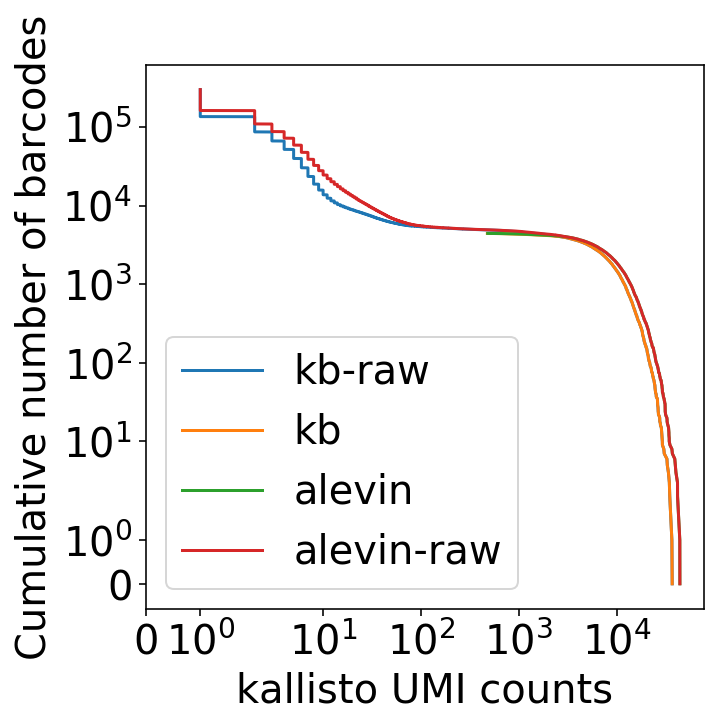

In [22]:
fig, ax = plt.subplots(figsize=(5,5))

## kb
x = np.sort(nd(kb_common.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, label="kb-raw")

x = np.sort(nd(kb_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, label="kb")


## Alevin
x = np.sort(nd(alevin_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, label="alevin")

x = np.sort(nd(alevin_common.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, label="alevin-raw")

ax.set(**{
    'xscale': 'symlog',
    'xlim': (0),
    'yscale': 'symlog',
    'xlabel': "kallisto UMI counts",
    'ylabel': "Cumulative number of barcodes"
 })
ax.legend()

fig.show()

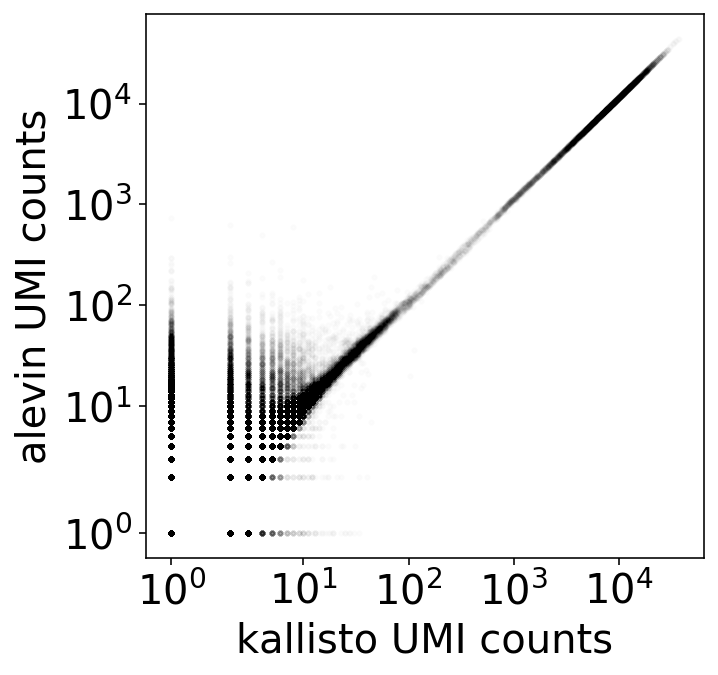

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = alevin_common.obs['counts'].values

ax.scatter(x,y, alpha = 0.01, s=5, color="k")

ax.set(**{
    'xscale': 'symlog',
    'yscale': 'symlog',
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'alevin UMI counts'
})


fig.show()

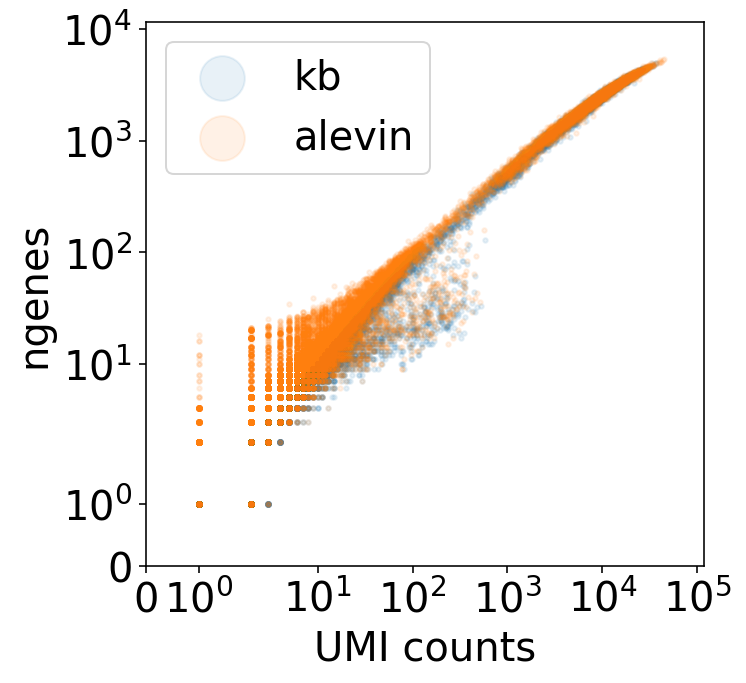

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = kb_common.obs['ngenes'].values

ax.scatter(x,y, alpha = 0.1, s=5, label='kb')

x = alevin_common.obs['counts'].values
y = alevin_common.obs['ngenes'].values

ax.scatter(x,y, alpha = 0.1, s=5, label='alevin')

ax.set(**{
    'xscale': 'symlog',
    'yscale': 'symlog',
    'xlim': 0,
    'ylim': 0,
    'xlabel': 'UMI counts',
    'ylabel': 'ngenes'
})

ax.legend(markerscale=10)

fig.show()

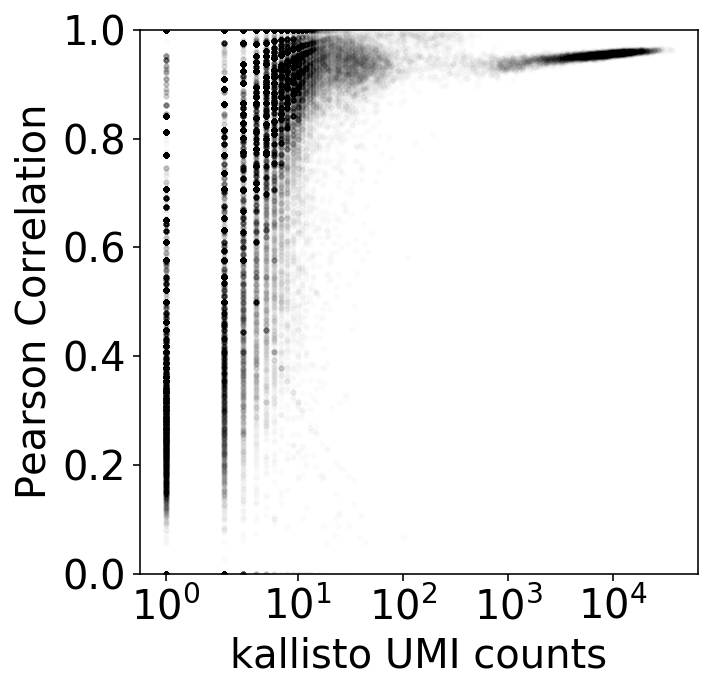

In [25]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = cc_raw

ax.scatter(x,y, s=5, alpha=0.01, color="k")

ax.set(**{
    'xscale': 'symlog',
    'ylim': (0,1),
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'Pearson Correlation'
})

fig.show()

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def counts_l1_dist(counts, nkk, nck, ax):
    nullfmt = NullFormatter()
    ax.scatter(counts, nkk, color=A_color, alpha=gridalpha, label="kallisto", s=dotsize)
    ax.scatter(counts, nck, color=B_color, alpha=gridalpha, label="alevin", s=dotsize)
    ax.set_xlabel("kallisto UMI counts", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ Distance", fontsize=fsize)

    ax.legend(fontsize=fsize, loc="upper left", markerscale=mscale)

    return ax

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max

    ax.hist(A, bins=best_bins, orientation=orientation, color="red", label="kallisto", alpha=1)
    ax.hist(B, bins=best_bins, orientation=orientation, color="blue", label="alevin", alpha=1)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kallisto", color="red")
    ax.scatter(xx, yy, label="alevin", color="blue")
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kallisto", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest alevin", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

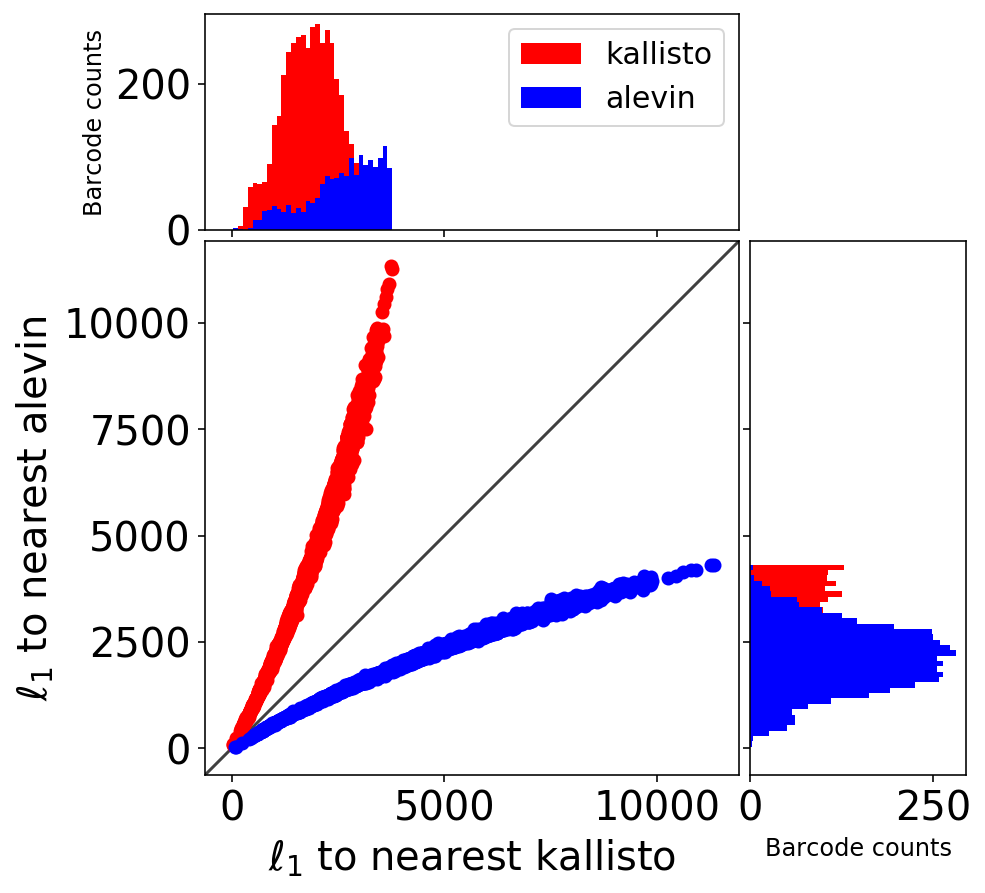

In [57]:
fig, ax = plt.subplots(figsize=(7,7))

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)

fig.show()

In [49]:
from matplotlib.ticker import NullFormatter

def counts_l1_dist(counts, nkk, nck, ax):
    nullfmt = NullFormatter()
    ax.scatter(counts, nkk, color='red', alpha=0.1, label="kallisto",     s=30)
    ax.scatter(counts, nck, color='blue', alpha=0.1, label="alevin", s=30)
    ax.set_xlabel("kallisto UMI counts", fontsize=20)
    ax.set_ylabel("$\ell_1$ Distance",   fontsize=20)

    ax.set_title("E.2", fontweight='bold', fontsize = 20, loc = 'left' )
    ax.legend(fontsize=20, loc="upper left", markerscale=3)

    return ax

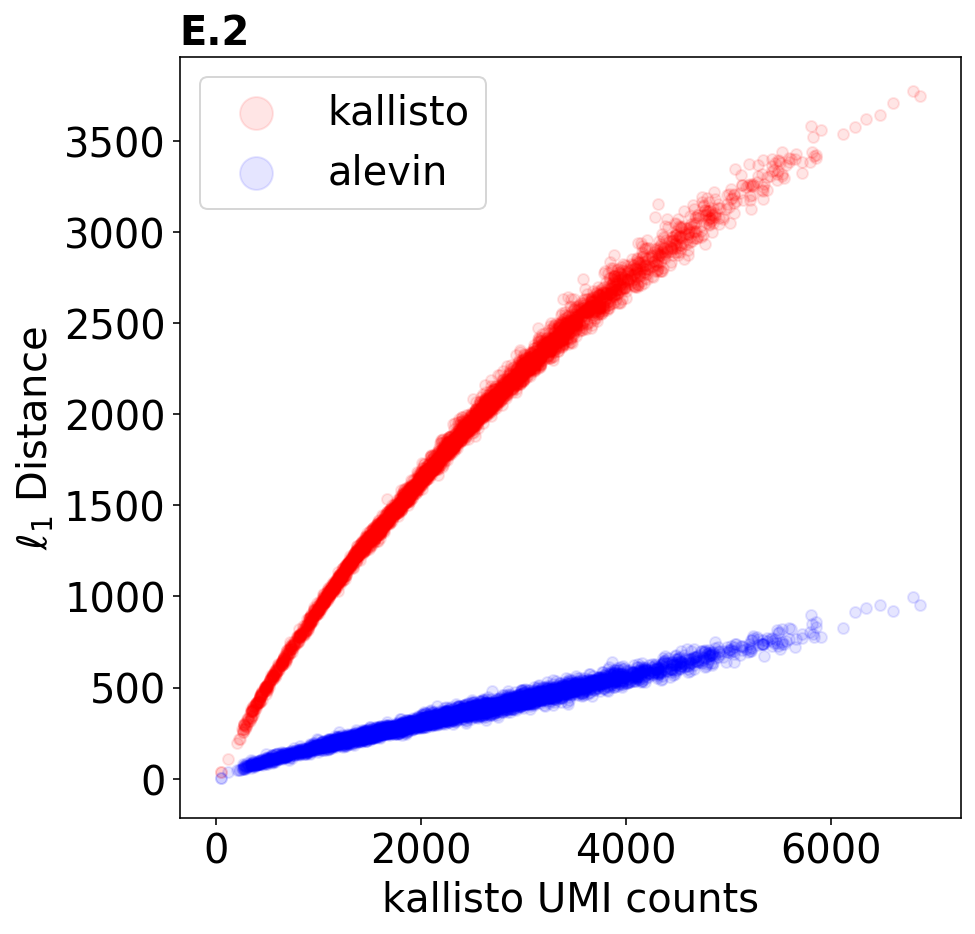

In [50]:
fig, ax = plt.subplots(figsize=(7,7))

cnts = nd(kb_common_cr.layers["log1p"].sum(1))
counts_l1_dist(cnts, dist_AA, dist_AB, ax)

fig.show()

In [41]:
alevin_raw_decoys[:, alevin_raw_decoys.var.index.isin(decoys['decoys'])].X.todense().sum()

0.0

In [ ]:
alev_r

In [40]:
alevin_raw.X.sum()

46208190.0